In [1]:
from fastai.vision.all import *
from fastai.vision.gan import *
import pathlib

In [2]:
from PIL import ImageDraw, ImageFont


In [3]:
path = untar_data(URLs.PETS)

In [4]:
path = pathlib.Path("data/train")

In [5]:
path_hr = path/ 'original'
path_lr = path/ 'blur'

In [6]:
path_hr

Path('data/train/original')

In [7]:
items = get_image_files(path_hr)


In [8]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])

In [9]:
path_hr

Path('data/train/original')

In [10]:
def get_dls(bs:int, size:int):
    "Generates two `GAN` DataLoaders"
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                     item_tfms=Resize(size),
                    batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)]
                    )
    dls = dblock.dataloaders(path_lr, bs=bs)
    dls.c = 3 # For 3 channel image
    return dls 

In [11]:
dls = get_dls(2, 512)

In [12]:
import kornia.losses

In [13]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [14]:
ssim_loss = partial(kornia.losses.ssim_loss, window_size=5)

In [15]:
learn = unet_learner(dls, resnet50, loss_func=ssim_loss, self_attention=True, norm_type=NormType.Weight, y_range=y_range)

In [16]:
learn.model.cuda();

In [17]:
b = list(learn.model.children())[0]

In [18]:
list(b.state_dict().items())[0][1].device

device(type='cuda', index=0)

In [19]:
learn.to_fp16()

In [20]:
learn.path = Path(".")

SuggestedLRs(valley=tensor(7.5858e-05))

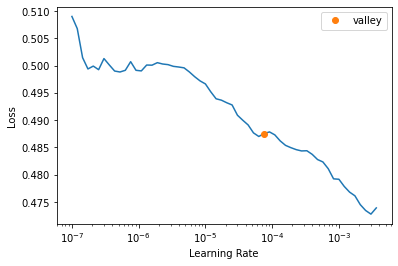

In [21]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.266356,0.275338,28:35
1,0.251427,0.267508,28:56


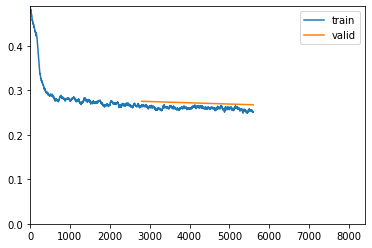

In [ ]:
learn.fit_one_cycle(3, lr_max=5e-4, wd=wd, cbs=ShowGraphCallback())

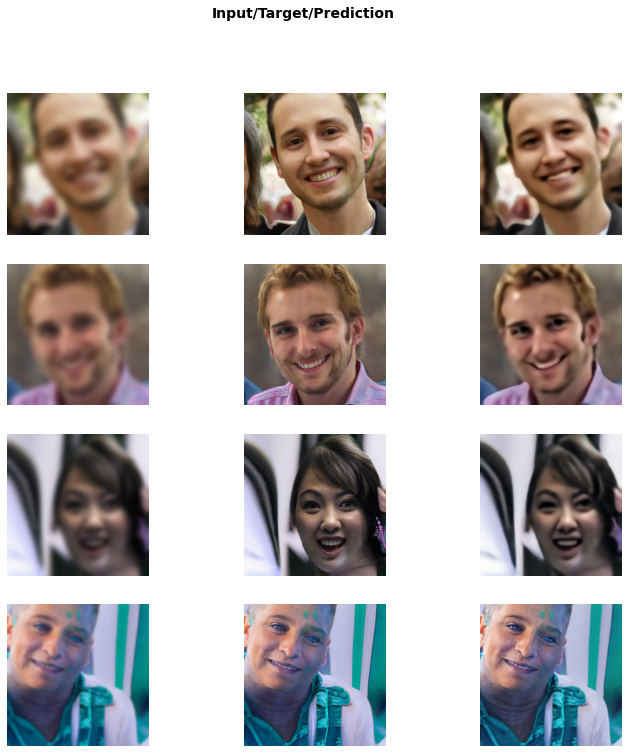

In [53]:
learn.show_results(max_n=4, figsize=(12,12))

In [ ]:
learn.show_results(max_n=4, figsize=(12,12))

In [23]:
learn.save("unet_resnet50_frozen")

Path('models/unet_resnet34_frozen.pth')

In [24]:
#@learn.show_results(max_n=4, figsize=(12,12))

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(10, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.256926,0.268960,05:18
1,0.263954,0.277468,05:19
2,0.257995,0.267733,05:21
3,0.255849,0.265854,05:21
4,0.257787,0.264599,05:21
5,0.249852,0.262704,05:21
6,0.251871,0.262076,05:21
7,0.248469,0.261170,05:19
8,0.249561,0.260519,05:20
9,0.250123,0.260530,05:20


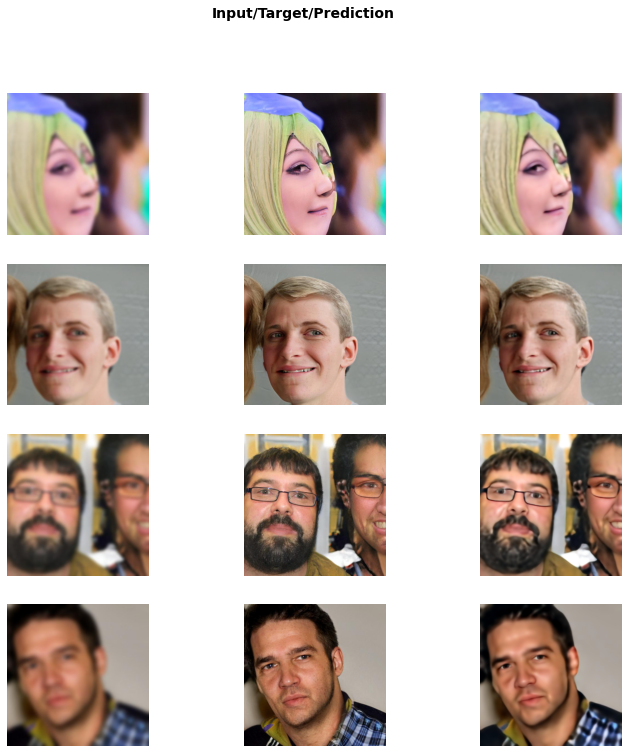

In [29]:
learn.show_results(max_n=4, figsize=(12,12))

In [27]:
learn.save("unet_resnet50")

Path('models/unet_resnet34.pth')

# Test predictions 

In [30]:
path_test = Path("data/test")

In [31]:
path_test

Path('data/test')

In [32]:
path_lr_test = path_test / "blur"

In [33]:
size = 512
bs = 8

test_dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
               get_items=get_image_files,
               get_y = lambda x: path_lr_test/x.name,
               splitter=RandomSplitter(valid_pct=0),
                 item_tfms=Resize(size),
                batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                )
test_dls = test_dblock.dataloaders(path_lr_test, bs=bs)
test_dls.c = 3

In [41]:
test_dls[0]

In [45]:
learn.load("unet_resnet34_frozen")

In [46]:
dl = test_dls.train.new(shuffle=False, drop_last=False)

In [47]:
preds, __ = learn.get_preds(dl=dl)

In [48]:
path_gen = path_test / "original"

In [49]:
import tqdm

In [50]:
def save_preds(dl, preds):
    "Save away predictions"
    names = dl.dataset.items
    for i,pred in tqdm.tqdm_notebook(enumerate(preds), total=len(preds)):
        dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
        arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
        Image.fromarray(arr).save(path_gen/names[i].name)

In [51]:
save_preds(dl, preds)

<ipython-input-50-1ef24c1f2f5b>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,pred in tqdm.tqdm_notebook(enumerate(preds), total=len(preds)):


  0%|          | 0/3000 [00:00<?, ?it/s]

In [52]:
!bash make_submission.sh

~/Projects/aicrowd/blitzxiii/face_deblurring/submission ~/Projects/aicrowd/blitzxiii/face_deblurring
  adding: notebook.ipynb (deflated 88%)
  adding: original/ (stored 0%)
  adding: original/tjmxz.jpg (deflated 2%)
  adding: original/6j2sf.jpg (deflated 1%)
  adding: original/4btec.jpg (deflated 1%)
  adding: original/74w3p.jpg (deflated 2%)
  adding: original/cgvet.jpg (deflated 1%)
  adding: original/p0yot.jpg (deflated 2%)
  adding: original/7xytg.jpg (deflated 1%)
  adding: original/yhhjr.jpg (deflated 3%)
  adding: original/m36wm.jpg (deflated 2%)
  adding: original/rg5nu.jpg (deflated 4%)
  adding: original/2b8ej.jpg (deflated 2%)
  adding: original/agl82.jpg (deflated 3%)
  adding: original/h0o1i.jpg (deflated 3%)
  adding: original/lliin.jpg (deflated 1%)
  adding: original/ksavj.jpg (deflated 5%)
  adding: original/tz7lq.jpg (deflated 6%)
  adding: original/ah2dc.jpg (deflated 2%)
  adding: original/92qqk.jpg (deflated 2%)
  adding: original/elmv8.jpg (deflated 4%)
  adding: 